In [1]:
import numpy as np
df = np.load("D:\Downloads\mnist.npz")

In [2]:
X_train = df["x_train"]
X_test = df["x_test"]
y_train = df["y_train"]
y_test = df["y_test"]

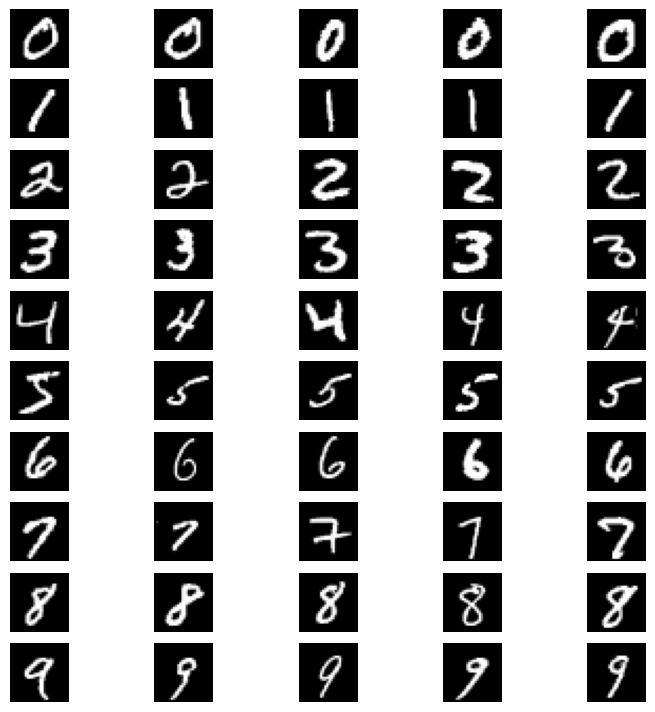

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 5, figsize=(9,9))
for i in range(10):
    class_samples = X_train[y_train == i][:5]
    for j in range(5):
        axes[i, j].imshow(class_samples[j], cmap='gray')
        axes[i, j].axis('off')

plt.show()


In [4]:
# !pip install cupy
# !pip install cupy-cuda12x
# !pip install cupy-cuda11x

In [5]:
# !pip install cupy

In [6]:
# import cupy as cp
import numpy as np
from numpy.linalg import det, inv
from scipy.stats import multivariate_normal

# Compute the prior probability of each class
prior_probabilities = [np.mean(y_train == i) for i in range(10)]

# Compute mean and covariance vectors for each class
mean_vectors = []
covariance_matrices = []

for i in range(10):
    class_samples = X_train[y_train == i]
    mean_vector = np.mean(class_samples, axis=0).flatten()
    covariance_matrix = np.cov(class_samples.reshape(class_samples.shape[0], -1), rowvar=False)

    mean_vectors.append(mean_vector)
    covariance_matrices.append(covariance_matrix)

# Convert the lists to NumPy arrays
mean_vectors = np.array(mean_vectors)
covariance_matrices = np.array(covariance_matrices)

print(mean_vectors.shape,covariance_matrices.shape)

def qda_gpu(x, prior, mean, covariance):
    noise_level = 1e-6
    covariance += noise_level * np.eye(covariance.shape[0])

    inv_covariance = np.linalg.inv(covariance)
    log_cov = np.linalg.slogdet(covariance)[1]

    x_flatten = x.reshape(x.shape[0], -1)

    # Calculate the quadratic form part of the QDA expression
    quadratic_form = np.sum((x_flatten @ inv_covariance) * x_flatten, axis=1)

    # Calculate the linear part of the QDA expression
    linear_part = np.sum(mean * (inv_covariance @ x_flatten.T).T, axis=1) * (-2)

    # Calculate the constant part of the QDA expression
    constant_part = mean @ inv_covariance @ mean

    # Combine all parts to get the final QDA expression
    qda_result = -0.5 * (quadratic_form + linear_part + constant_part + log_cov) + np.log(prior)

    return qda_result

# Convert data to cupy arrays for GPU acceleration
X_test_gpu = np.asarray(X_test)
mean_vectors_gpu = np.asarray(mean_vectors)
covariance_matrices = np.asarray(covariance_matrices)
stacked_covariances = np.stack(covariance_matrices)
stacked_covariances_gpu = np.asarray(stacked_covariances)

# Perform QDA on GPU
qda_results_gpu = np.array([qda_gpu(X_test_gpu, prior_probabilities[i], mean_vectors_gpu[i], stacked_covariances_gpu[i]) for i in range(10)])

# Choose the class with the highest QDA score as the predicted class on GPU
predicted_classes_gpu = np.argmax(qda_results_gpu, axis=0)

# Convert back to NumPy for further analysis
predicted_classes_cpu = predicted_classes_gpu

# Evaluate the performance of your QDA model on the test set
accuracy_gpu = np.mean(predicted_classes_cpu == y_test)
print("QDA GPU Accuracy:", accuracy_gpu)


(10, 784) (10, 784, 784)
QDA GPU Accuracy: 0.6834


In [7]:
# Convert the predicted classes from GPU to NumPy array for comparison
predicted_classes_cpu = predicted_classes_gpu

# Calculate overall accuracy
overall_accuracy = np.mean(predicted_classes_cpu == y_test)
print("Overall Accuracy:", overall_accuracy)

# Calculate class-wise accuracy
class_accuracy = []
for i in range(10):
    correct_predictions = np.sum((predicted_classes_cpu == y_test) & (y_test == i))
    total_samples = np.sum(y_test == i)
    accuracy = correct_predictions / total_samples
    class_accuracy.append((i, accuracy))

print("Class-wise Accuracy:")
for class_acc in class_accuracy:
    print(f"Class {class_acc[0]}: {class_acc[1]}")


Overall Accuracy: 0.6834
Class-wise Accuracy:
Class 0: 0.960204081632653
Class 1: 0.9374449339207048
Class 2: 0.4680232558139535
Class 3: 0.5118811881188119
Class 4: 0.45213849287169044
Class 5: 0.29596412556053814
Class 6: 0.9436325678496869
Class 7: 0.43287937743190663
Class 8: 0.8542094455852156
Class 9: 0.931615460852329
